In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib

#Data subsetting and loading

#Subsetting and selecting features of interest for the probelm described in Clustering_Report.pdf
fields = ['hcpcs_code',
 'hcpcs_description',
 'line_srvc_cnt',
 'bene_unique_cnt',
 'average_Medicare_allowed_amt',
 'average_submitted_chrg_amt']

df = pd.read_csv("Medicare_Provider_Util_Payment_PUF_CY2015.txt", sep='\t', usecols=fields)

#Just 1 row has nan values, dropping nan values
df = df.dropna()

#Printing shape of dataframe to be sure we loaded correct data
print("Shape of loaded data: ", df.shape)

#Checking correlation between service counts, number of unique beneficiaries, 
#average medicare allowed amount and average submitted charge amount
df.corr()

Shape of loaded data:  (9497891, 6)


,line_srvc_cnt,bene_unique_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt
line_srvc_cnt,1.000000,0.441004,-0.011438,-0.010937
bene_unique_cnt,0.441004,1.000000,-0.008735,-0.009361
average_Medicare_allowed_amt,-0.011438,-0.008735,1.000000,0.748461
average_submitted_chrg_amt,-0.010937,-0.009361,0.748461,1.000000


In [174]:
#Data Preprocessing Step. Takes some time as the data is large.

#Calculating total medicare allowed amount and total submitted charge amount for each provider
df['total_Medicare_allowed_amt'] = df.apply(lambda row: row.line_srvc_cnt * row.average_Medicare_allowed_amt, axis=1)
df['total_submitted_charge_amt'] = df.apply(lambda row: row.line_srvc_cnt * row.average_submitted_chrg_amt, axis=1)

#Dropping columns as they are not needed anymore for analysis (memory efficiency)
df.drop(['average_Medicare_allowed_amt'], axis = 1, inplace = True)
df.drop(['average_submitted_chrg_amt'], axis = 1, inplace = True)

#Checking things look good
df.head()

,hcpcs_code,hcpcs_description,line_srvc_cnt,bene_unique_cnt,total_Medicare_allowed_amt,total_submitted_charge_amt
1,99217,Hospital observation care discharge,23.0,23.0,1671.640000,7544.000000
2,99219,Hospital observation care typically 50 minutes,18.0,18.0,2445.300000,11052.000000
3,99221,"Initial hospital inpatient care, typically 30 ...",59.0,58.0,5980.540000,19664.000000
4,99222,"Initial hospital inpatient care, typically 50 ...",132.0,130.0,18349.380001,47057.000000
5,99223,"Initial hospital inpatient care, typically 70 ...",220.0,215.0,45140.910001,138861.000001


In [175]:
#Data aggregation for business problem
#Creating hybrid features for analysis

#Aggregating hcpcs_code to get count of number of providers for each unique service
count_physicians = pd.DataFrame(df['hcpcs_code'].value_counts().reset_index())
count_physicians = count_physicians.rename(index=str, columns={"hcpcs_code": "num_physicians_cnt", "index":"hcpcs_code"})

#Aggregating data for unique services to find per service totals for number of services, number of unique beneficiaries, 
#total medicare allowed amount and total submitted charge amount 
groups = df.groupby('hcpcs_code').sum().reset_index()

#Joining physician counts with rest of the aggregated data
groups = groups.join(count_physicians.set_index('hcpcs_code'), on='hcpcs_code')

#Checking things look good
groups.head()

,hcpcs_code,line_srvc_cnt,bene_unique_cnt,total_Medicare_allowed_amt,total_submitted_charge_amt,num_physicians_cnt
0,00100,60.0,57.0,1.601183e+04,8.924960e+04,4
1,00102,130.0,129.0,1.232808e+04,6.590150e+04,5
2,00103,71318.0,69564.0,1.102565e+07,6.425369e+07,2441
3,00104,142799.0,66466.0,1.275516e+07,8.594126e+07,2939
4,00120,2425.0,2223.0,4.867235e+05,3.525604e+06,110


In [176]:
groups['submitted_chrg_to_allowed_amt'] = groups.apply(lambda row: row.total_submitted_charge_amt/row.total_Medicare_allowed_amt, axis=1)
groups['average_submitted_chrg_amt'] = groups.apply(lambda row: row.total_submitted_charge_amt/row.line_srvc_cnt, axis=1)

#Dropping columns as they are not needed anymore for analysis (memory efficiency)
groups.drop(['total_Medicare_allowed_amt'], axis = 1, inplace = True)
groups.drop(['total_submitted_charge_amt'], axis = 1, inplace = True)

#Adding back hcpcs-description. Will need later
hcpcs_desc = df.drop_duplicates('hcpcs_code')
hcpcs_desc = hcpcs_desc[['hcpcs_code','hcpcs_description']]
groups = groups.join(hcpcs_desc.set_index('hcpcs_code'), on='hcpcs_code')

#Checking things look good
groups.head()

,hcpcs_code,line_srvc_cnt,bene_unique_cnt,num_physicians_cnt,submitted_chrg_to_allowed_amt,average_submitted_chrg_amt,hcpcs_description
0,00100,60.0,57.0,4,5.573979,1487.493333,Anesthesia for procedure on salivary gland wit...
1,00102,130.0,129.0,5,5.345642,506.934615,Anesthesia for procedure to repair lip defect ...
2,00103,71318.0,69564.0,2441,5.827657,900.946364,Anesthesia for procedure on eyelid
3,00104,142799.0,66466.0,2939,6.737764,601.833783,Anesthesia for electric shock treatment
4,00120,2425.0,2223.0,110,7.243546,1453.857336,Anesthesia for biopsy of external middle and i...


In [177]:
#Checking correlation between aggregated and hybrid features
groups.corr()

,line_srvc_cnt,bene_unique_cnt,num_physicians_cnt,submitted_chrg_to_allowed_amt,average_submitted_chrg_amt
line_srvc_cnt,1.000000,0.652451,0.562266,-0.003775,-0.050029
bene_unique_cnt,0.652451,1.000000,0.890454,-0.015823,-0.048547
num_physicians_cnt,0.562266,0.890454,1.000000,-0.020269,-0.056629
submitted_chrg_to_allowed_amt,-0.003775,-0.015823,-0.020269,1.000000,0.049920
average_submitted_chrg_amt,-0.050029,-0.048547,-0.056629,0.049920,1.000000


In [178]:
#Exploratory Analysis on data features

#Defining generic function for plotting
def plot_hist(df_series, bins = 100, range_x_min = 0, range_x_max = 2000, range_y_min = 0, range_y_max = 600, 
             x_label = '', y_label ='', title= ''):
    plt.figure()
    df_series.plot.hist(alpha=0.75, bins=bins, range=(range_x_min, range_x_max))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.axis([range_x_min, range_x_max, range_y_min, range_y_max])
    plt.grid(True)
   
    fig = plt.gcf()
    fig.set_size_inches(9, 5)
    plt.show()
    

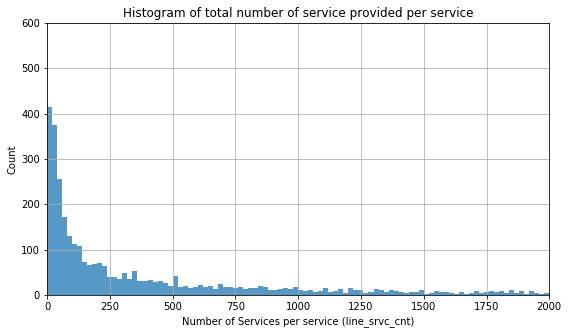

In [179]:
#Plotting service counts per service to see distribution. Looks lognormal.
plot_hist(groups['line_srvc_cnt'], bins = 100, range_x_min = 0, range_x_max = 2000, range_y_min = 0, range_y_max = 600, 
             x_label = "Number of Services per service (line_srvc_cnt)",
             y_label = "Count",
             title = "Histogram of total number of service provided per service")

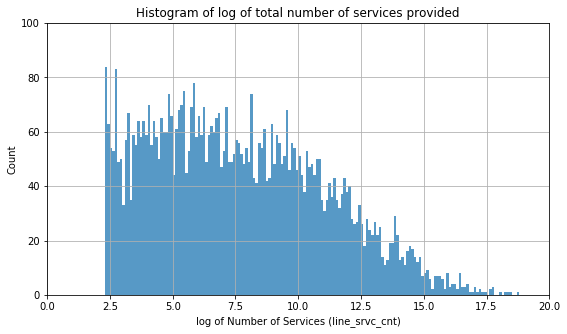

In [180]:
#Plotting log(service counts per service) to see distribution. Looks a bit more normal than above.
plot_hist(groups['line_srvc_cnt'].apply(np.log), bins = 200, range_x_min = 0, range_x_max = 20, range_y_min = 0, range_y_max = 100, 
             x_label = "log of Number of Services (line_srvc_cnt)",
             y_label = "Count",
             title = "Histogram of log of total number of services provided")

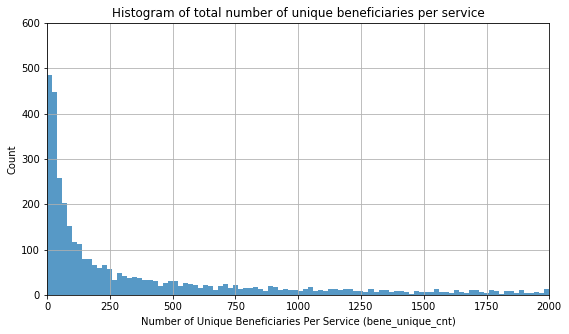

In [181]:
#Plotting number of unique beneficiaries per service to see distribution. Looks lognormal.
plot_hist(groups['bene_unique_cnt'], bins = 100, range_x_min = 0, range_x_max = 2000, range_y_min = 0, range_y_max = 600, 
             x_label = "Number of Unique Beneficiaries Per Service (bene_unique_cnt)",
             y_label = "Count",
             title = "Histogram of total number of unique beneficiaries per service")

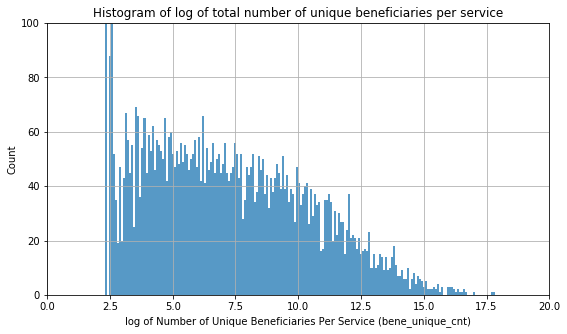

In [182]:
#Plotting log(number of unique beneficiaries per service) to see distribution. Looks a bit more normal than above.
plot_hist(groups['bene_unique_cnt'].apply(np.log), bins = 250, range_x_min = 0, range_x_max = 20, range_y_min = 0, range_y_max = 100, 
             x_label = "log of Number of Unique Beneficiaries Per Service (bene_unique_cnt)",
             y_label = "Count",
             title = "Histogram of log of total number of unique beneficiaries per service")

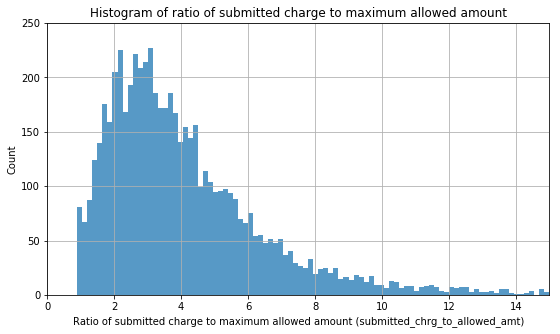

In [183]:
#Plotting submitted charge to maximum allowed amount per service to see distribution. Looks lognormal.
plot_hist(groups['submitted_chrg_to_allowed_amt'], bins = 100, range_x_min = 0, range_x_max = 15, range_y_min = 0, range_y_max = 250, 
             x_label = "Ratio of submitted charge to maximum allowed amount (submitted_chrg_to_allowed_amt)",
             y_label = "Count",
             title = "Histogram of ratio of submitted charge to maximum allowed amount")

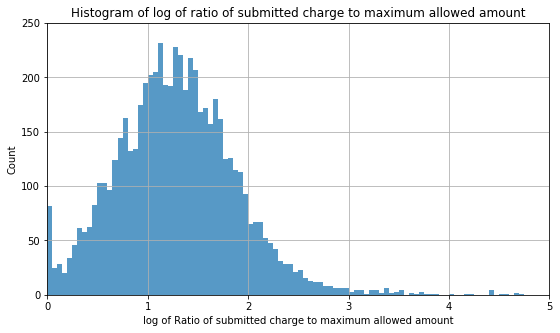

In [184]:
#Plotting log(submitted charge to maximum allowed amount per service) to see distribution. Looks much better.
plot_hist(groups['submitted_chrg_to_allowed_amt'].apply(np.log), bins = 100, range_x_min = 0, range_x_max = 5, range_y_min = 0, range_y_max = 250, 
             x_label = "log of Ratio of submitted charge to maximum allowed amount",
             y_label = "Count",
             title = "Histogram of log of ratio of submitted charge to maximum allowed amount")

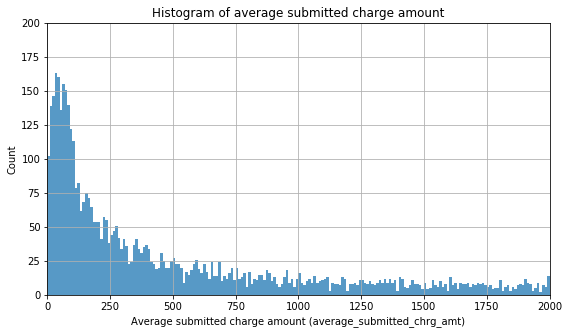

In [185]:
#Plotting average submitted charge amount per service to see distribution. Looks lognormal.
plot_hist(groups['average_submitted_chrg_amt'], bins = 200, range_x_min = 0, range_x_max = 2000, range_y_min = 0, range_y_max = 200, 
             x_label = "Average submitted charge amount (average_submitted_chrg_amt)",
             y_label = "Count",
             title = "Histogram of average submitted charge amount")

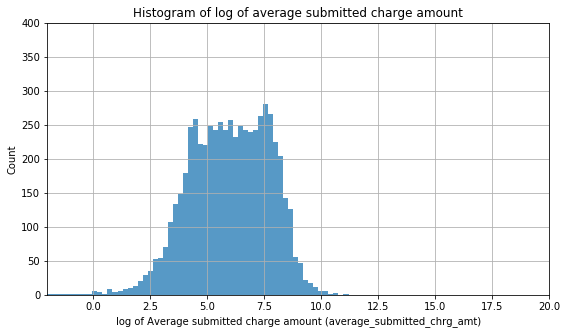

In [186]:
#Plotting log(average submitted charge amount per service) to see distribution. Looks much better.
plot_hist(groups['average_submitted_chrg_amt'].apply(np.log), bins = 100, range_x_min = -2, range_x_max = 20, range_y_min = 0, range_y_max = 400, 
             x_label = "log of Average submitted charge amount (average_submitted_chrg_amt)",
             y_label = "Count",
             title = "Histogram of log of average submitted charge amount")

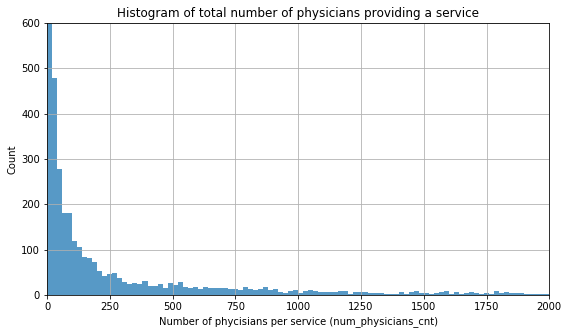

In [187]:
#Plotting number of physicians per service to see distribution. Looks much better. 
plot_hist(groups['num_physicians_cnt'], bins = 100, range_x_min = 0, range_x_max = 2000, range_y_min = 0, range_y_max = 600, 
             x_label = "Number of phycisians per service (num_physicians_cnt)",
             y_label = "Count",
             title = "Histogram of total number of physicians providing a service")

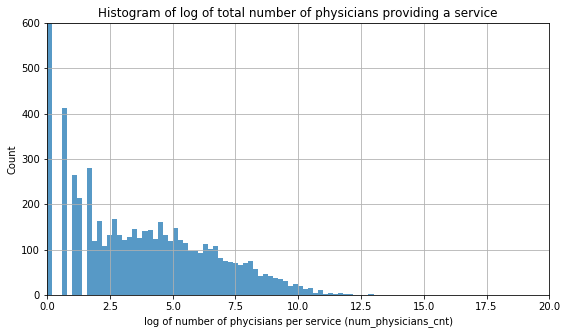

In [188]:
#Plotting log(number of physicians per service) to see distribution. Looks much better. 
#However, there are a bunch of 0's we need to be careful about.
plot_hist(groups['num_physicians_cnt'].apply(np.log), bins = 100, range_x_min = 0, range_x_max = 20, range_y_min = 0, range_y_max = 600, 
             x_label = "log of number of phycisians per service (num_physicians_cnt)",
             y_label = "Count",
             title = "Histogram of log of total number of physicians providing a service")

In [189]:
#Preparing final feature set for analysis. All the features needed to be passed through a log function for getting more normally distributed.
groups['l_average_submitted_chrg_amt'] = groups['average_submitted_chrg_amt'].apply(np.log)
groups['l_submitted_chrg_to_allowed_amt'] = groups['submitted_chrg_to_allowed_amt'].apply(np.log)
groups['l_bene_unique_cnt'] = groups['bene_unique_cnt'].apply(np.log)
groups['l_line_srvc_cnt'] = groups['line_srvc_cnt'].apply(np.log)
groups['l_num_physicians_cnt'] = groups['num_physicians_cnt'].apply(np.log)

#Checking correlation between features
groups.corr()

,line_srvc_cnt,bene_unique_cnt,num_physicians_cnt,submitted_chrg_to_allowed_amt,average_submitted_chrg_amt,l_average_submitted_chrg_amt,l_submitted_chrg_to_allowed_amt,l_bene_unique_cnt,l_line_srvc_cnt,l_num_physicians_cnt
line_srvc_cnt,1.000000,0.652451,0.562266,-0.003775,-0.050029,-0.153414,-0.029283,0.223949,0.272533,0.212198
bene_unique_cnt,0.652451,1.000000,0.890454,-0.015823,-0.048547,-0.085994,-0.038486,0.276795,0.260839,0.263393
num_physicians_cnt,0.562266,0.890454,1.000000,-0.020269,-0.056629,-0.084110,-0.058778,0.321578,0.301734,0.335478
submitted_chrg_to_allowed_amt,-0.003775,-0.015823,-0.020269,1.000000,0.049920,-0.017164,0.533579,-0.001293,0.009787,0.009503
average_submitted_chrg_amt,-0.050029,-0.048547,-0.056629,0.049920,1.000000,0.623403,0.180967,-0.246376,-0.271908,-0.196082
l_average_submitted_chrg_amt,-0.153414,-0.085994,-0.084110,-0.017164,0.623403,1.000000,0.194854,-0.366753,-0.465761,-0.265411
l_submitted_chrg_to_allowed_amt,-0.029283,-0.038486,-0.058778,0.533579,0.180967,0.194854,1.000000,-0.010113,-0.034695,0.031015
l_bene_unique_cnt,0.223949,0.276795,0.321578,-0.001293,-0.246376,-0.366753,-0.010113,1.000000,0.959854,0.956134
l_line_srvc_cnt,0.272533,0.260839,0.301734,0.009787,-0.271908,-0.465761,-0.034695,0.959854,1.000000,0.918251
l_num_physicians_cnt,0.212198,0.263393,0.335478,0.009503,-0.196082,-0.265411,0.031015,0.956134,0.918251,1.000000


In [190]:
#Seems like after conversion to log features, there is a high correlation between 
#l_bene_unique_cnt, l_line_srvc_cnt and l_num_physicians_cnt per service. So we should select only 1 out of these 3 features.
#Selecting l_num_physicians_cnt out of the 3 as it gives the best silloute score

#Performing normalization
from sklearn.preprocessing import scale

final_features = ['l_average_submitted_chrg_amt','l_submitted_chrg_to_allowed_amt','l_num_physicians_cnt']

training_df = groups[final_features]
training_array = scale(training_df.values)

#Checking to see if the array looks good
training_array

array([[ 0.75617629,  0.69881164, -0.8470364 ],
       [ 0.13982852,  0.62986555, -0.76616078],
       [ 0.46909052,  0.77217262,  1.477591  ],
       ..., 
       [-0.54822731, -0.87935321,  0.65315044],
       [-0.26493057, -0.83144925, -1.34948164],
       [ 1.33223073, -1.67474586,  0.67007668]])

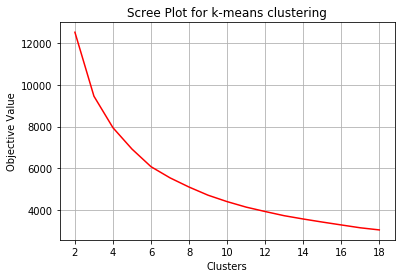

In [191]:
#Clustering using k-means and generating scree plot to find the 'kink'
from sklearn.cluster import KMeans

kmeans_list = []
kmeans_inertia = []
cluster_numbers = range(2,19)
for i in cluster_numbers:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10).fit(training_array)
    kmeans_list.append(kmeans)
    kmeans_inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(cluster_numbers, kmeans_inertia, 'r')
plt.xlabel('Clusters')
plt.ylabel('Objective Value')
plt.title('Scree Plot for k-means clustering')
plt.grid(True)
plt.show()

In [192]:
#Selecting cluster count = 7 from the scree plot
#Running silhouette metric to gauge the fit of elements in clustering 
from sklearn import metrics

selected_kmeans = kmeans_list[5] 
print("Cluster centers for selected k: \n", selected_kmeans.cluster_centers_)

lab = selected_kmeans.labels_
unique, counts = np.unique(lab, return_counts=True)
print("Cluster numbers: ", unique)
print("Corresponding count of points in the clusters: ", counts)

print("Average Silhouette metric: ", metrics.silhouette_score(training_array, selected_kmeans.labels_,
                                      metric='euclidean',
                                      sample_size=groups.line_srvc_cnt.size))

Cluster centers for selected k: 
 [[-0.85481101  0.51473993  0.10190296]
 [ 0.50026857 -0.60464561 -0.84080352]
 [ 1.01834327  0.97049089 -0.80040762]
 [-1.06419291 -1.1762968  -0.63088168]
 [ 0.7722547   0.31765191  0.69164175]
 [-0.64357404 -0.48672911  1.37093911]
 [-1.62504898  2.82977256  0.55764482]]
Cluster numbers:  [0 1 2 3 4 5 6]
Corresponding count of points in the clusters:  [ 876 1179 1042  733  970 1068  115]
Average Silhouette metric:  0.277033936415


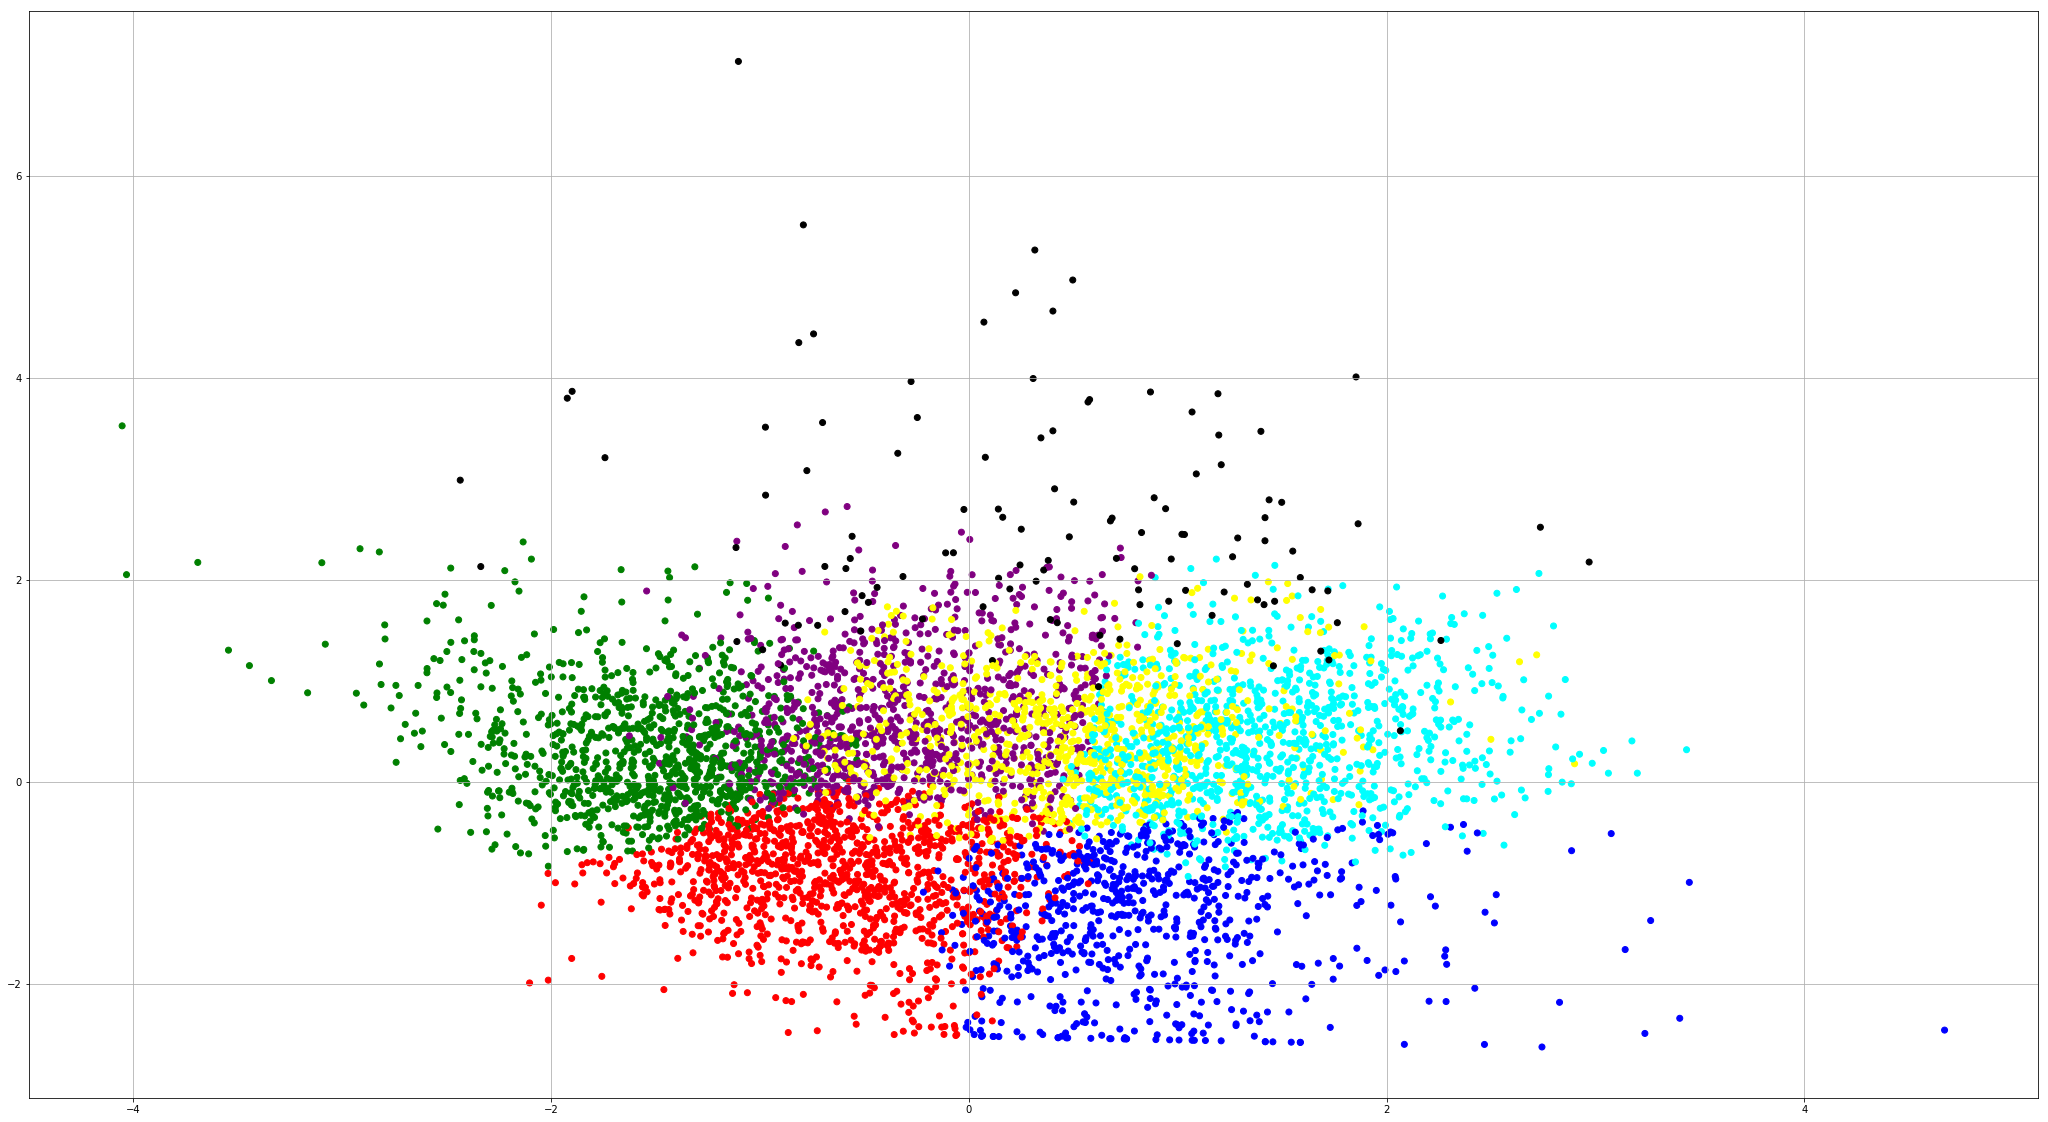

In [200]:
#Reducing to 2 dimensions and vizualising
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(training_array)
lab = selected_kmeans.labels_
colors = ['yellow','red','green','blue','purple','cyan','black']

plt.figure()
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=lab, cmap=matplotlib.colors.ListedColormap(colors))    
plt.grid(True)
fig = plt.gcf()
fig.set_size_inches(36, 20)
plt.show()


In [198]:
#Joining back with aggregated services data to find cluster of interest
cluster_number = 4 ###This number needs to be selected based on cluster centroids

clusters = pd.DataFrame(lab, columns=['cluster'])
final_clustering = groups.join(clusters)
services_to_look = final_clustering.loc[final_clustering['cluster'] == cluster_number] 

services_to_look.to_csv(r'services_to_look.csv', index=None, sep=',', mode='a')
services_to_look

,hcpcs_code,line_srvc_cnt,bene_unique_cnt,num_physicians_cnt,submitted_chrg_to_allowed_amt,average_submitted_chrg_amt,hcpcs_description,l_average_submitted_chrg_amt,l_submitted_chrg_to_allowed_amt,l_bene_unique_cnt,l_line_srvc_cnt,l_num_physicians_cnt,cluster
2,00103,71318.0,69564.0,2441,5.827657,900.946364,Anesthesia for procedure on eyelid,6.803446,1.762615,11.150002,11.174904,7.800163,4
3,00104,142799.0,66466.0,2939,6.737764,601.833783,Anesthesia for electric shock treatment,6.399981,1.907728,11.104446,11.869193,7.985825,4
4,00120,2425.0,2223.0,110,7.243546,1453.857336,Anesthesia for biopsy of external middle and i...,7.281976,1.980111,7.706613,7.793587,4.700480,4
6,00140,90030.0,83069.0,2560,5.893136,858.723583,Anesthesia for procedure on eye,6.755447,1.773788,11.327427,11.407898,7.847763,4
7,00142,1989403.0,1734195.0,22742,5.883096,623.172369,Anesthesia for lens surgery,6.434823,1.772083,14.366054,14.503345,10.031969,4
8,00144,9694.0,9214.0,430,6.475718,1097.201146,Anesthesia for procedure on eye for corneal tr...,7.000518,1.868060,9.128479,9.179262,6.063785,4
9,00145,80580.0,77816.0,2805,6.341538,1076.372226,Anesthesia for retinal surgery,6.981352,1.847121,11.262102,11.297006,7.939159,4
11,00160,9220.0,9114.0,555,6.388286,1043.566636,Anesthesia for procedure on nose and sinus,6.950400,1.854466,9.117567,9.129130,6.318968,4
13,00170,3264.0,3137.0,156,5.725569,913.589979,Anesthesia for procedure on mouth including bi...,6.817382,1.744942,8.051022,8.090709,5.049856,4
17,00210,6334.0,6221.0,332,6.405696,3478.623636,Anesthesia for procedure on brain,8.154392,1.857188,8.735686,8.753687,5.805135,4
